# Imports

In [51]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.api import tsa

# Load data

### Load the hourly NO$_2$ data

In [2]:
species = "NO2"
url = "http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json"
start_date = "2000-01-01"
end_date = "2021-01-01"

In [3]:
NO2 = LAQNData(url, species, start_date, end_date)

### Load the hourly meteorology data

In [4]:
heathrow = MetData("Heathrow")

### Load the daily disposable income data

In [52]:
income = IncomeData()

### Load the daily mortality per capita data

In [53]:
mortality = HealthData()

In [54]:
mortality_df = mortality.read("mortality-scaled")

In [55]:
mortality_df["deaths_per_100k"] = mortality_df["deaths"]*100000

In [56]:
mortality_df.shape

(13698, 2)

# Process data + plots

## Daily data

In [7]:
daily_dates = mortality_df.index

### Resample the hourly NO$_2$ data using a custom date list

Only retain the NO$_2$ data up to the final mortality datapoint:

In [11]:
#daily_NO2_df = NO2.resample_time_and_log(sites=NO2.site_codes, date_index=daily_dates)

In [12]:
#daily_NO2_df = NO2.read("laqn-resample", NO2.site_codes)

In [13]:
#daily_NO2_df.shape

### Spatially average the NO$_2$ data for all of London

In [14]:
#NO2_df = NO2.regional_average_and_log(NO2.site_codes)

In [15]:
NO2_df = NO2.read("laqn-regional")

In [16]:
NO2_df.shape

(6940, 1)

#### Scatter plot mortality vs NO$_2$

In [17]:
NO2_df = NO2_df.join(mortality_df)

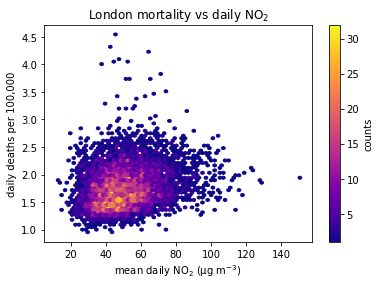

<Figure size 1440x1080 with 0 Axes>

In [18]:
plt.hexbin(NO2_df.mean_NO2, NO2_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.title("London mortality vs daily NO$_2$")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

### Resample the hourly meteorology data using a custom date list

Only retain the met data up to the final mortality datapoint:

In [19]:
#daily_met_df = heathrow.resample_time_and_log(daily_dates)

In [20]:
daily_met_df = heathrow.read(["temperature"], "met-resample")

In [21]:
daily_met_df.shape

(13694, 1)

In [22]:
temperature_df = pd.DataFrame(daily_met_df["temperature"]).join(mortality_df)

#### Scatter plot of mortality vs temperature

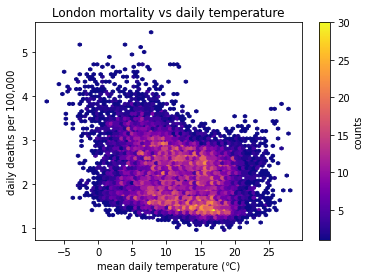

<Figure size 1440x1080 with 0 Axes>

In [23]:
plt.hexbin(temperature_df.temperature, temperature_df.deaths_per_100k, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean daily temperature (℃)")
plt.title("London mortality vs daily temperature")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

### Scatter plot of NO$_2$ vs temperature

#### Daily averages

In [24]:
daily_df = pd.DataFrame(NO2_df["mean_NO2"]).join(temperature_df)

In [25]:
daily_df.columns

Index(['mean_NO2', 'temperature', 'deaths', 'deaths_per_100k'], dtype='object')

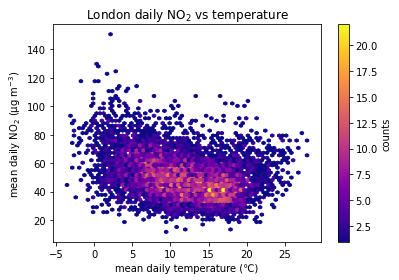

<Figure size 1440x1080 with 0 Axes>

In [26]:
plt.hexbin(daily_df.temperature, daily_df.mean_NO2, cmap=cm.plasma, gridsize=70, mincnt=1)
plt.ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.xlabel("mean daily temperature (℃)")
plt.title("London daily NO$_2$ vs temperature")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

### Spatially average the disposable income data for all of London

In [3]:
#income_df = income.regional_average_and_log()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [57]:
income_df = income.read("income-regional")

In [58]:
income_df.shape

(7671, 1)

In [59]:
#income_df["income"].plot()

#### Scatter plot mortality vs disposable income

In [12]:
income_df = income_df.join(mortality_df)

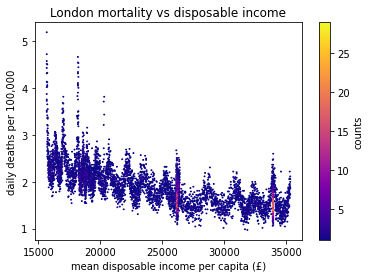

<Figure size 1440x1080 with 0 Axes>

In [19]:
plt.hexbin(income_df.income, income_df.deaths_per_100k, cmap=cm.plasma, gridsize=250, mincnt=1)
plt.ylabel("daily deaths per 100,000")
plt.xlabel("mean disposable income per capita (£)")
plt.title("London mortality vs disposable income")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()

## Time series decomposition: trends

**Trends** represent how the variable is changing overall through time.
**Seasonality** shows how the variable changes within a given period e.g. year, month.
**Residual** activity is not explained by the trend or seasonality.

Additive model: 
`y(t) = Trend(t) + Seasonality(t) + Residual(t)`

Multiplicative model:
`y(t) = Trend(t) * Seasonality(t) * Residual(t)`

#### Mortality data

Here we use the `seasonal_decompose()` function with an additive model. Note that we have to manually set `period` (for filtering) to `365`, because otherwise the function by default looks for weekly (`period=7`) trends when given daily data (inferred from the `DatetimeIndex`).

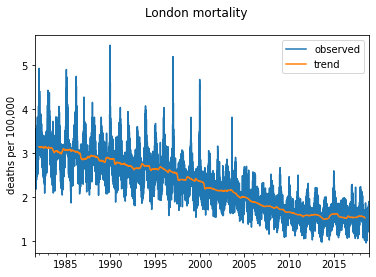

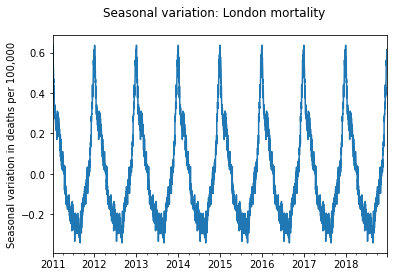

In [27]:
decomp = tsa.seasonal_decompose(mortality_df["deaths_per_100k"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("deaths per 100,000")
plt.suptitle("London mortality")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in deaths per 100,000")
plt.suptitle("Seasonal variation: London mortality")
plt.show()

#### NO$_2$ data

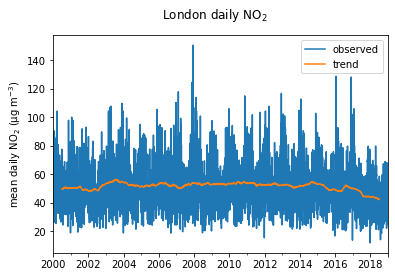

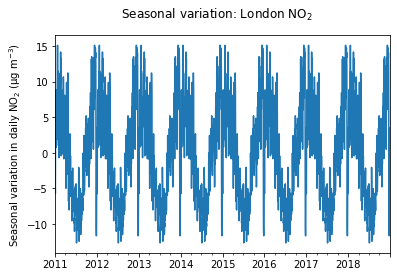

In [28]:
decomp = tsa.seasonal_decompose(daily_df["mean_NO2"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("mean daily NO$_2$ (µg m$^{-3}$)")
plt.suptitle("London daily NO$_2$")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in daily NO$_2$ (µg m$^{-3}$)")
plt.suptitle("Seasonal variation: London NO$_2$")
plt.show()

#### Temperature data

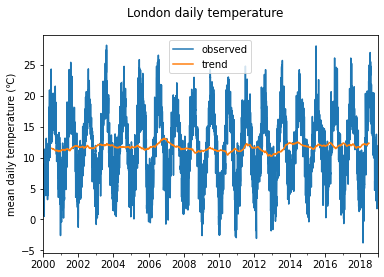

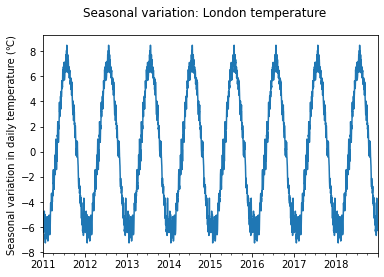

In [29]:
decomp = tsa.seasonal_decompose(daily_df["temperature"], model="additive", period=365)
decomp_df = pd.DataFrame({"observed":decomp.observed, "trend":decomp.trend, "seasonal":decomp.seasonal, "residual":decomp.resid})

decomp_df["observed"].plot()
decomp_df["trend"].plot()
plt.legend()
plt.ylabel("mean daily temperature (℃)")
plt.suptitle("London daily temperature")
plt.show()

decomp_df.loc[decomp_df.index.year>2010]["seasonal"].plot()
plt.ylabel("Seasonal variation in daily temperature (℃)")
plt.suptitle("Seasonal variation: London temperature")
plt.show()

#### Disposable income data

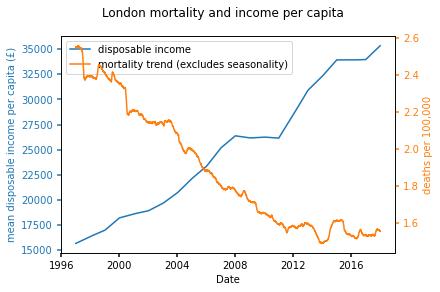

In [50]:
decomp = tsa.seasonal_decompose(mortality_df["deaths_per_100k"], model="additive", period=365)
decomp_df = pd.DataFrame(income_df["income"]).join(pd.DataFrame({"mortality_trend":decomp.trend}))

# decomp_df["income"].plot(label="income").set_ylabel("mean daily disposable income (£)")
# decomp_df["mortality_trend"].plot(label="mortality").set_ylabel("mortality trend")
# plt.twinx()
# plt.legend()
# plt.ylabel("mean daily disposable income (£)")
# plt.suptitle("London disposable income")
# plt.show()


fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot(decomp_df.index, decomp_df["income"],"tab:blue", label="disposable income")
p2, = twin1.plot(decomp_df.index, decomp_df["mortality_trend"], "tab:orange", label="mortality trend (excludes seasonality)")

ax.set_xlabel("Date")
ax.set_ylabel("mean disposable income per capita (£)")
twin1.set_ylabel("deaths per 100,000")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2])
plt.suptitle("London mortality and income per capita")

plt.show()

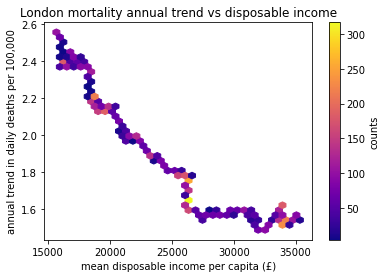

<Figure size 1440x1080 with 0 Axes>

In [74]:
plt.hexbin(decomp_df.income, decomp_df.mortality_trend, cmap=cm.plasma, gridsize=35, mincnt=1)
plt.ylabel("annual trend in daily deaths per 100,000")
plt.xlabel("mean disposable income per capita (£)")
plt.title("London mortality annual trend vs disposable income")
plt.colorbar().set_label("counts")
plt.figure(figsize=(20,15))
plt.show()